# Tutorial: Processing Marker Data

**Author:** Robbin Romijnders  
**Date Created:** Sep 28, 2021  
**Last Modified:** Sep 28, 2021

## Introduction
In this tutorial, the data files with optical motion capture data are firstly loaded, and then the marker data are subject to the following processing steps:

1. Correct for any gaps in the marker position data, 
2. Low-pass filter the marker position data,
3. Detect any instances of intial foot contact (IC) and final foot contact (FC)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from lib.utils import _load_file
from lib.preprocessing import _predict_missing_markers, _butter_lowpass
from lib.analysis import _get_gait_events_from_OMC
import os
from scipy.signal import find_peaks

In [2]:
# Set data directory
PARENT_FOLDER = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"

# Get a list of participant ids
participant_ids = [folder_name for folder_name in os.listdir(PARENT_FOLDER) if folder_name.startswith("pp")]
print(f"Number of participants: {len(participant_ids)}")

Number of participants: 120


In [3]:
# Trial to investigate
trial_name = "walk_preferred"

# Loop over the participants
for (ix_participant, participant_id) in enumerate(participant_ids[6:7]):

    # Get a list of OMC data files
    omc_filenames = [file_name for file_name in os.listdir(os.path.join(PARENT_FOLDER, participant_id, "optical")) if file_name.endswith(".mat")]

    # Select only the file corresponding to the trial of interest
    ix_omc_filename = [ix for ix in range(len(omc_filenames)) if ("walk_preferred" in omc_filenames[ix])]
    if len(ix_omc_filename) > 0:
        ix_omc_filename = ix_omc_filename[0]
        omc_filename = omc_filenames[ix_omc_filename]

        # Check if there is an equivalent IMU file
        if os.path.isfile(os.path.join(PARENT_FOLDER, participant_id, "imu", omc_filename.replace("omc_", "imu_"))):
            imu_filename = omc_filename.replace("omc_", "imu_")

            # Load the data
            omc_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "optical", omc_filename))
            imu_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "imu", imu_filename))
print(f"Participant: {participant_id}")

Participant: pp007


We now have two dictionaries, `omc_data` and `imu_data`, that contain all the relevant information concerning our trial:
- `fs`: sampling frequency, in Hz
- `pos`: (N, 4, M) array, the marker position data, in mm; with N time steps (or frames), 3 dimensions + 1 error, M markers
- `calibration_file`: the corresponding file of the calibration procedure, in case joint angles are to be calibrated
- `marker_location`: array, with the marker positions  

Or, in case of the IMU data:
- `acc`, `gyro`, `magn`: (N, 4, M) array, the accelerometer, gyroscope, and magnetometer data, respectively

## Preprocessing
The marker position data are first interpolated to get rid of any missing data. Next, the data are low-pass filtered to reduce the effects of high-frequency noise.

In [4]:
# Get sampling frequency
fs = omc_data["fs"]
print(f"Sampling frequency: {fs} Hz")

Sampling frequency: 200 Hz


### Fill gaps in marker data

In [5]:
M = omc_data["pos"][:,:3,:]  # get marker position data
n_time_steps, n_dimensions, n_markers = M.shape
M = np.reshape(M, (n_time_steps, 3*n_markers), order="F")
M = _predict_missing_markers(M)

Low-pass filter the (filled) marker data.

In [6]:
M = _butter_lowpass(M, fs)
M = np.reshape(M, (n_time_steps, n_dimensions, n_markers), order="F")

## Transform Data
Next, we express the marker position data in a local, $\mathcal{B}$ ody-fixed, coordinate frame. The $\mathcal{B}$-frame is composed of the unit vectors $\hat{\mathbf{e}}_{x'}$, $\hat{\mathbf{e}}_{y'}$, $\hat{\mathbf{e}}_{z'}$, where the global, i $\mathcal{N}$ ertial frame, is made up from the unit vectors $\hat{\mathbf{e}}_{X}$, $\hat{\mathbf{e}}_{Y}$, $\hat{\mathbf{e}}_{Z}$

In [7]:
start_1 = np.squeeze(M[:,:,np.argwhere(omc_data["marker_location"]=='start_1')[:,0]], axis=-1)
start_2 = np.squeeze(M[:,:,np.argwhere(omc_data["marker_location"]=='start_2')[:,0]], axis=-1)
end_1 = np.squeeze(M[:,:,np.argwhere(omc_data["marker_location"]=='end_1')[:,0]], axis=-1)
end_2 = np.squeeze(M[:,:,np.argwhere(omc_data["marker_location"]=='end_2')[:,0]], axis=-1)

In [8]:
l_psis = np.squeeze(M[:,:,np.argwhere(omc_data["marker_location"]=='l_psis')[:,0]], axis=-1)
l_asis = np.squeeze(M[:,:,np.argwhere(omc_data["marker_location"]=='l_asis')[:,0]], axis=-1)
r_psis = np.squeeze(M[:,:,np.argwhere(omc_data["marker_location"]=='r_psis')[:,0]], axis=-1)
r_asis = np.squeeze(M[:,:,np.argwhere(omc_data["marker_location"]=='r_asis')[:,0]], axis=-1)

Calculate a virtual center of mass (CoM) by averaging the positions of the iliac spine markers.

In [9]:
com = ( l_psis + l_asis + r_psis + r_asis ) / 4

In [19]:
com

array([[-201.09008018, -273.49837339,  949.27801818],
       [-201.20791961, -273.5220104 ,  949.26838232],
       [-201.33194261, -273.54895754,  949.25607305],
       ...,
       [6066.47146577,  781.91427628,  896.51732299],
       [6067.0115388 ,  782.03981004,  896.42579227],
       [6067.44995027,  782.14324488,  896.3483246 ]])

The unit vector, $\hat{\mathbf{e}}_{x'}$ is given by the movement of this virtual CoM marker.

In [10]:
e_x = np.empty_like(com)
e_x[1:,:] = com[1:,:] - com[:-1,:]
e_x[0,:] = e_x[1,:]

# Normalize to unit length
e_x = np.divide(e_x, np.expand_dims(np.linalg.norm(e_x, axis=1), axis=-1))

# Define the vertical unit vector
e_z = np.zeros_like(e_x)
e_z[:,2] = 1

# Compute the mediolateral unit vector as the cross product
e_y = np.cross(e_z, e_x)
e_y = np.divide(e_y, np.expand_dims(np.linalg.norm(e_y, axis=1), axis=-1))

# Compute the final anteroposterior unit vector
e_x = np.cross(e_y, e_z)

In [20]:
e_x, e_y, e_z

(array([[-0.98046991, -0.19666914,  0.        ],
        [-0.98046991, -0.19666914,  0.        ],
        [-0.97719988, -0.21232146,  0.        ],
        ...,
        [ 0.97487323,  0.22276036, -0.        ],
        [ 0.97403373,  0.22640294, -0.        ],
        [ 0.9732788 ,  0.2296266 , -0.        ]]),
 array([[ 0.19666914, -0.98046991,  0.        ],
        [ 0.19666914, -0.98046991,  0.        ],
        [ 0.21232146, -0.97719988,  0.        ],
        ...,
        [-0.22276036,  0.97487323,  0.        ],
        [-0.22640294,  0.97403373,  0.        ],
        [-0.2296266 ,  0.9732788 ,  0.        ]]),
 array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]))

Given a position vector $\mathbf{r}$, we can choose to express it in the global inertial frame, ${}^{\mathcal{N}}\mathbf{r} = \begin{pmatrix}r_{X} & r_{Y} & r_{Z}\end{pmatrix}^{\mathsf{T}}$, or equally valid, in the local body-fixed frame, ${}^{\mathcal{B}}\mathbf{r} = \begin{pmatrix}r_{x'} & r_{y'} & r_{z'}\end{pmatrix}^{\mathsf{T}}$. Likewise, we can also express the unit vectors of the global frame in terms of the local frame, i.e.:
$${}^{\mathcal{B}}\hat{\mathbf{e}}_{X} = \begin{pmatrix}\hat{\mathbf{e}}_{X} \cdot \hat{\mathbf{e}}_{x'}\\
\hat{\mathbf{e}}_{X} \cdot \hat{\mathbf{e}}_{y'}\\
\hat{\mathbf{e}}_{X} \cdot \hat{\mathbf{e}}_{z'}\end{pmatrix},\quad {}^{\mathcal{B}}\hat{\mathbf{e}}_{Y} = \begin{pmatrix}\hat{\mathbf{e}}_{Y} \cdot \hat{\mathbf{e}}_{x'}\\
\hat{\mathbf{e}}_{Y} \cdot \hat{\mathbf{e}}_{y'}\\
\hat{\mathbf{e}}_{Y} \cdot \hat{\mathbf{e}}_{z'}\end{pmatrix},\quad {}^{\mathcal{B}}\hat{\mathbf{e}}_{Z} = \begin{pmatrix}\hat{\mathbf{e}}_{Z} \cdot \hat{\mathbf{e}}_{x'}\\
\hat{\mathbf{e}}_{Z} \cdot \hat{\mathbf{e}}_{y'}\\
\hat{\mathbf{e}}_{Z} \cdot \hat{\mathbf{e}}_{z'}\end{pmatrix}$$  

The conversion from one frame to the other, for a given vector, is then given by:
$$\begin{align}
{}^{\mathcal{B}}\mathbf{r} = r_{x'} {}^{\mathcal{B}}\hat{\mathbf{e}}_{x'} + r_{y'} {}^{\mathcal{B}}\hat{\mathbf{e}}_{y'} + r_{z'} {}^{\mathcal{B}}\hat{\mathbf{e}}_{z'} &= r_{X} {}^{\mathcal{B}}\hat{\mathbf{e}}_{X} + r_{Y} {}^{\mathcal{B}}\hat{\mathbf{e}}_{Y} + r_{Z} {}^{\mathcal{B}}\hat{\mathbf{e}}_{Z}\\
\begin{pmatrix}1 \\ 0 \\ 0\end{pmatrix} r_{x'} + \begin{pmatrix}0 \\ 1 \\ 0\end{pmatrix} r_{y'} + \begin{pmatrix}0 \\ 0 \\ 1\end{pmatrix} r_{z'} &=\begin{pmatrix}\hat{\mathbf{e}}_{X} \cdot \hat{\mathbf{e}}_{x'}\\
\hat{\mathbf{e}}_{X} \cdot \hat{\mathbf{e}}_{y'}\\
\hat{\mathbf{e}}_{X} \cdot \hat{\mathbf{e}}_{z'}\end{pmatrix} r_{X} + \begin{pmatrix}\hat{\mathbf{e}}_{Y} \cdot \hat{\mathbf{e}}_{x'}\\
\hat{\mathbf{e}}_{Y} \cdot \hat{\mathbf{e}}_{y'}\\
\hat{\mathbf{e}}_{Y} \cdot \hat{\mathbf{e}}_{z'}\end{pmatrix} r_{Y} + \begin{pmatrix}\hat{\mathbf{e}}_{Z} \cdot \hat{\mathbf{e}}_{x'}\\
\hat{\mathbf{e}}_{Z} \cdot \hat{\mathbf{e}}_{y'}\\
\hat{\mathbf{e}}_{Z} \cdot \hat{\mathbf{e}}_{z'}\end{pmatrix} r_{Z}\\
\begin{pmatrix}r_{x'}\\r_{y'}\\r_{z'}\end{pmatrix} &= \begin{pmatrix}
\hat{\mathbf{e}}_{X} \cdot \hat{\mathbf{e}}_{x'} & \hat{\mathbf{e}}_{Y} \cdot \hat{\mathbf{e}}_{x'} & \hat{\mathbf{e}}_{Z} \cdot \hat{\mathbf{e}}_{x'}\\
\hat{\mathbf{e}}_{X} \cdot \hat{\mathbf{e}}_{y'} & \hat{\mathbf{e}}_{Y} \cdot \hat{\mathbf{e}}_{y'} & \hat{\mathbf{e}}_{Z} \cdot \hat{\mathbf{e}}_{y'}\\
\hat{\mathbf{e}}_{X} \cdot \hat{\mathbf{e}}_{z'} & \hat{\mathbf{e}}_{Y} \cdot \hat{\mathbf{e}}_{z'} & \hat{\mathbf{e}}_{Z} \cdot \hat{\mathbf{e}}_{z'}
\end{pmatrix} \begin{pmatrix}r_{X}\\r_{Y}\\r_{Z}\end{pmatrix}\\
{}^{\mathcal{B}}\mathbf{r} &= \begin{pmatrix} \vdots & \vdots & \vdots\\
{}^{\mathcal{B}}\hat{\mathbf{e}}_{X} & {}^{\mathcal{B}}\hat{\mathbf{e}}_{Y} & {}^{\mathcal{B}}\hat{\mathbf{e}}_{Z}\\
 \vdots & \vdots & \vdots\end{pmatrix} {}^{\mathcal{N}}\mathbf{r}\\
  &= \begin{pmatrix} \cdots & ({}^{\mathcal{N}}\hat{\mathbf{e}}_{x'})^{\mathsf{T}} & \cdots\\
\cdots & ({}^{\mathcal{N}}\hat{\mathbf{e}}_{y'})^{\mathsf{T}} & \cdots\\
 \cdots & ({}^{\mathcal{N}}\hat{\mathbf{e}}_{z'})^{\mathsf{T}} & \cdots\end{pmatrix} {}^{\mathcal{N}}\mathbf{r}\\
 \rightarrow {}^{\mathcal{B}}\mathbf{r} &= {}^{\mathcal{B}}\mathbf{C}_{\mathcal{N}} {}^{\mathcal{N}}\mathbf{r}
\end{align}$$

In our case, based on the direction of movement of the virtual center of mass, we have obtained expressions of our local vectors in the global frame, ${}^{\mathcal{N}}\hat{\mathbf{e}}_{i'}, i \in \{x, y, z\}$. Now, if we compute any vectors expressed in the global $\mathcal{N}$-frame, we can convert it to the local $\mathcal{B}$-frame by matrix-vector multiplication using the rotation matrix.

In [11]:
print(M.shape)

(2396, 3, 51)


In [12]:
X = np.zeros_like(M)  # preallocate the transformed data

# For each time step
for ix_time in range(M.shape[0]):

    # Setup the rotation matrix
    R = np.array([e_x[ix_time,:], e_y[ix_time,:], e_z[ix_time,:]])

    # For each marker
    for ix_marker in range(M.shape[-1]):

        # Get the position vector 
        pos = M[ix_time,:,ix_marker]
        
        # Express vector in local coords
        X[ix_time,:,ix_marker] = R @ pos

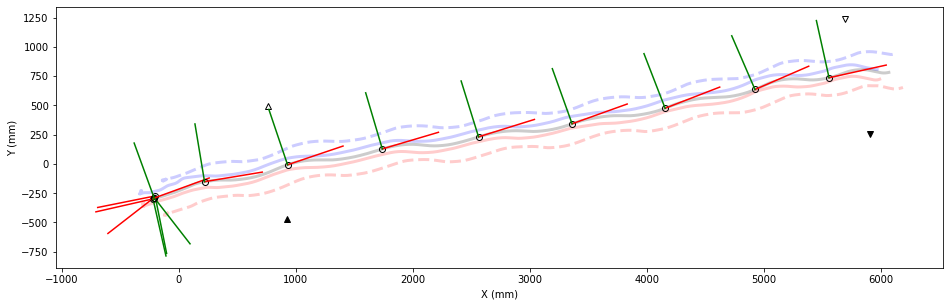

In [13]:
K = 500  # scaling factor to visualize the unit vectors
fig, ax = plt.subplots(1, 1, figsize=(25.6, 4.8))
ax.plot(np.mean(start_1[:,0]), np.mean(start_1[:,1]), '^', mfc='none', mec='k')
ax.plot(np.mean(start_2[:,0]), np.mean(start_2[:,1]), '^', mfc='k', mec='k')
ax.plot(np.mean(end_1[:,0]), np.mean(end_1[:,1]), 'v', mfc='none', mec='k')
ax.plot(np.mean(end_2[:,0]), np.mean(end_2[:,1]), 'v', mfc='k', mec='k')
ax.plot(l_psis[:,0], l_psis[:,1], '-', c=(0, 0, 1, 0.2), lw=3)
ax.plot(l_asis[:,0], l_asis[:,1], '--', c=(0, 0, 1, 0.2), lw=3)
ax.plot(r_psis[:,0], r_psis[:,1], '-', c=(1, 0, 0, 0.2), lw=3)
ax.plot(r_asis[:,0], r_asis[:,1], '--', c=(1, 0, 0, 0.2), lw=3)
ax.plot(com[:,0], com[:,1], '-', c=(0, 0, 0, 0.2), lw=3)
for ti in range(0, com.shape[0], fs):
    ax.plot(com[ti,0], com[ti,1], 'o', mfc='none', mec='k')
    ax.plot([com[ti,0], com[ti,0]+K*e_x[ti,0]], [com[ti,1], com[ti,1]+K*e_x[ti,1]], 'r-')
    ax.plot([com[ti,0], com[ti,0]+K*e_y[ti,0]], [com[ti,1], com[ti,1]+K*e_y[ti,1]], 'g-')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_aspect('equal')
plt.show()
del K

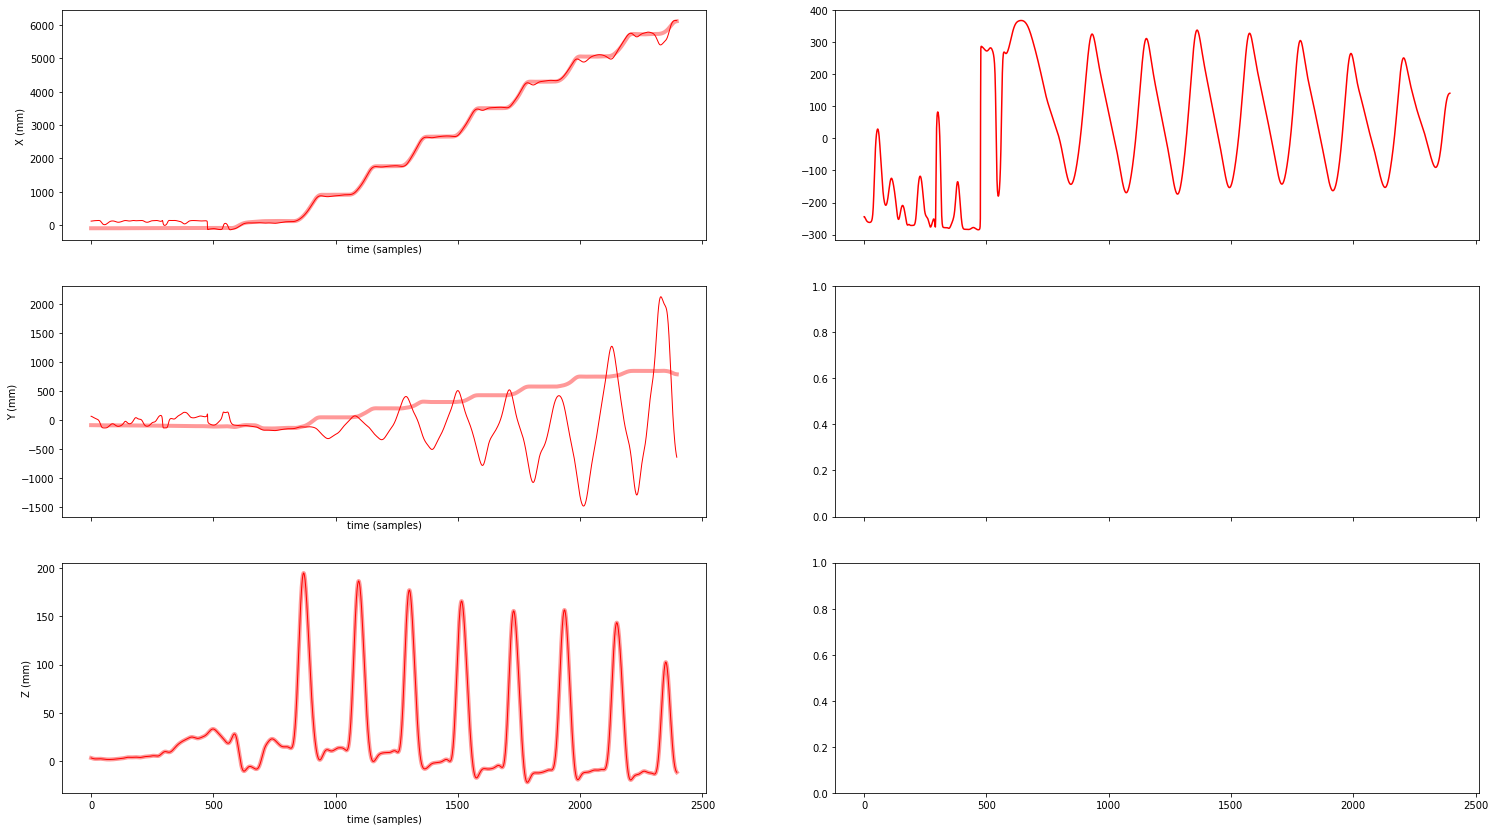

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(25.4, 14.4), sharex=True)
axs[0][0].plot(np.arange(M.shape[0]), M[:,0,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]], '-', c=(1, 0, 0, 0.4), lw=4)
axs[0][0].plot(np.arange(X.shape[0]), X[:,0,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]], '-', c=(1, 0, 0, 1), lw=1)
axs[0][0].set_xlabel('time (samples)')
axs[0][0].set_ylabel('X (mm)')

axs[1][0].plot(np.arange(M.shape[0]), M[:,1,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]], '-', c=(1, 0, 0, 0.4), lw=4)
axs[1][0].plot(np.arange(X.shape[0]), X[:,1,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]], '-', c=(1, 0, 0, 1), lw=1)
axs[1][0].set_xlabel('time (samples)')
axs[1][0].set_ylabel('Y (mm)')

axs[2][0].plot(np.arange(M.shape[0]), M[:,2,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]], '-', c=(1, 0, 0, 0.4), lw=4)
axs[2][0].plot(np.arange(X.shape[0]), X[:,2,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]], '-', c=(1, 0, 0, 1), lw=1)
axs[2][0].set_xlabel('time (samples)')
axs[2][0].set_ylabel('Z (mm)')

axs[0][1].plot(np.arange(X.shape[0]), np.squeeze(X[:,0,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]], axis=-1)-np.squeeze(X[:,0,np.argwhere(omc_data["marker_location"]=='l_psis')[:,0]], axis=-1), 'r-')

plt.show()

## Gait Event Detection
Now, let us detect gait events according to O'Connor *et al.* (2007) and Zeni Jr *et al.* (2008), respectively.

In [15]:
l_mid_foot = np.squeeze((X[:,:,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]] + X[:,:,np.argwhere(omc_data["marker_location"]=='l_toe')[:,0]])/2, axis=-1)
r_mid_foot = np.squeeze((X[:,:,np.argwhere(omc_data["marker_location"]=='r_heel')[:,0]] + X[:,:,np.argwhere(omc_data["marker_location"]=='r_toe')[:,0]])/2, axis=-1)

In [16]:
l_mid_foot_vel = np.zeros_like(l_mid_foot)
l_mid_foot_vel[1:,:] = (l_mid_foot[1:,:] - l_mid_foot[:-1,:])/(1/fs)


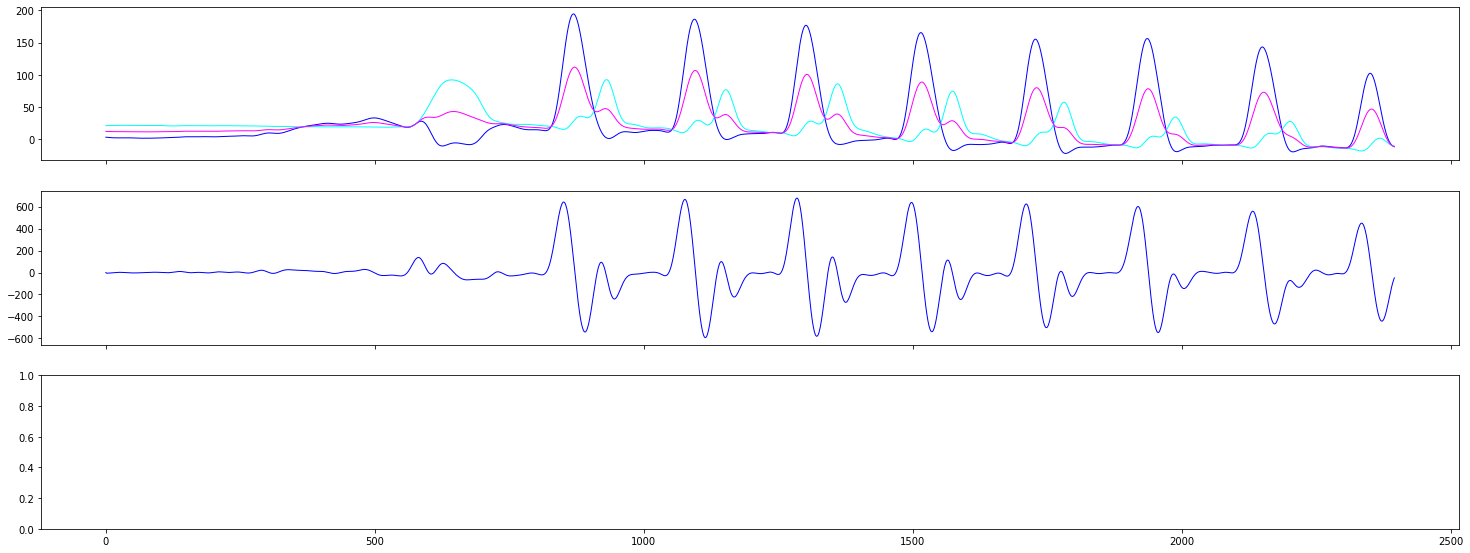

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(25.4, 9.6), sharex=True)
axs[0].plot(np.arange(X.shape[0]), np.squeeze(X[:,2,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]], axis=-1), '-', c=(0, 0, 1, 1), lw=1)
axs[0].plot(np.arange(X.shape[0]), np.squeeze(X[:,2,np.argwhere(omc_data["marker_location"]=='l_toe')[:,0]], axis=-1), '-', c=(0, 1, 1, 1), lw=1)
axs[0].plot(np.arange(X.shape[0]), l_mid_foot[:,2], '-', c=(1, 0, 1, 1), lw=1)
axs[1].plot(np.arange(l_mid_foot_vel.shape[0]), l_mid_foot_vel[:,2], '-', c=(0, 0, 1, 1), lw=1)
# axs[1].plot(np.arange(X.shape[0]), r_mid_foot_vel[:,2], '-', c=(1, 0, 0, 1), lw=1)
plt.show()

In [18]:
l_ix_IC, l_ix_FC, r_ix_IC, r_ix_FC = _get_gait_events_from_OMC(filtered_data, fs, omc_data["marker_location"], method="OConnor")
l_jx_IC, l_jx_FC, r_jx_IC, r_jx_FC = _get_gait_events_from_OMC(filtered_data, fs, omc_data["marker_location"], method="Zeni")

NameError: name 'filtered_data' is not defined

Get the marker position data, and calculate the corresponding velocity signals, according to the two papers mentioned before.

In [ ]:
l_heel_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0][0]]
l_toe_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='l_toe')[:,0][0]]
l_psis_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='l_psis')[:,0][0]]

r_heel_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='r_heel')[:,0][0]]
r_toe_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='r_toe')[:,0][0]]
r_psis_pos = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=='r_psis')[:,0][0]]

# Get sampling frequency
fs = omc_data["fs"]

# Calculate midpoint for the posterior iliac spine markers
mid_psis_pos = ( l_psis_pos + r_psis_pos ) / 2

In [ ]:
# For O'Connor et al. (2007), let us calculate the foot centre position and velocity data
l_foot_centre_pos = ( l_heel_pos + l_toe_pos ) / 2
r_foot_centre_pos = ( r_heel_pos + r_toe_pos ) / 2
l_foot_centre_vel = ( l_foot_centre_pos[1:,:] - l_foot_centre_pos[:-1,:] ) / ( 1/fs )
r_foot_centre_vel = ( r_foot_centre_pos[1:,:] - r_foot_centre_pos[:-1,:] ) / ( 1/fs )

In [ ]:
# For Zeni Jr et al. (2008), let us calculate the relative position to the psis marker
l_heel_pos_rel = ( l_heel_pos - l_psis_pos )
l_toe_pos_rel = ( l_toe_pos - l_psis_pos )
r_heel_pos_rel = ( r_heel_pos - r_psis_pos )
r_toe_pos_rel = ( r_toe_pos - r_psis_pos )

In [ ]:
# Visualize
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Position data
fig.add_trace(go.Scatter(x=np.arange(l_heel_pos.shape[0]), y=l_heel_pos[:,2], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_heel'), row=1, col=1)
fig.add_trace(go.Scatter(x=l_ix_IC, y=l_heel_pos[l_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(l_toe_pos.shape[0]), y=l_toe_pos[:,2], mode='lines', line=dict(color='rgba(0, 0, 255, 0.3)', width=1), name='l_toe'), row=1, col=1)
fig.add_trace(go.Scatter(x=l_jx_FC, y=l_toe_pos[l_jx_FC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_heel_pos.shape[0]), y=r_heel_pos[:,2], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='r_heel'), row=1, col=1)
fig.add_trace(go.Scatter(x=r_ix_IC, y=r_heel_pos[r_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_toe_pos.shape[0]), y=r_toe_pos[:,2], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=1), name='r_toe'), row=1, col=1)
fig.add_trace(go.Scatter(x=r_jx_FC, y=r_toe_pos[r_jx_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=1, col=1)

# Velocity (O'Connor et al.)
fig.add_trace(go.Scatter(x=np.arange(l_foot_centre_vel.shape[0]), y=l_foot_centre_vel[:,-1], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_mid_foot_vel_z'), row=2, col=1)
fig.add_trace(go.Scatter(x=l_ix_IC, y=l_foot_centre_vel[l_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=2, col=1)
# fig.add_trace(go.Scatter(x=l_ix_FC, y=l_foot_centre_vel[l_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(0, 0, 255, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_foot_centre_vel.shape[0]), y=r_foot_centre_vel[:,-1], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='r_mid_foot_vel_z'), row=2, col=1)
fig.add_trace(go.Scatter(x=r_ix_IC, y=r_foot_centre_vel[r_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=2, col=1)
# fig.add_trace(go.Scatter(x=r_ix_FC, y=r_foot_centre_vel[r_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=2, col=1)

# Relative position (Zeni Jr et al.)
fig.add_trace(go.Scatter(x=np.arange(l_heel_pos_rel.shape[0]), y=l_heel_pos_rel[:,0], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(l_toe_pos_rel.shape[0]), y=l_toe_pos_rel[:,0], mode='lines', line=dict(color='rgba(0, 0, 255, 0.3)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
# fig.add_trace(go.Scatter(x=l_jx_IC, y=l_heel_pos_rel[l_jx_IC,0], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=l_jx_FC, y=l_toe_pos_rel[l_jx_FC,0], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(0, 0, 255, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_heel_pos_rel.shape[0]), y=r_heel_pos_rel[:,0], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_toe_pos_rel.shape[0]), y=r_toe_pos_rel[:,0], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
# fig.add_trace(go.Scatter(x=r_jx_IC, y=r_heel_pos_rel[r_jx_IC,0], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=r_jx_FC, y=r_toe_pos_rel[r_jx_FC,0], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=3, col=1)

fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.show()

## Start and end of trial

In [ ]:
start_1 = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=="start_1")[:,0][0]]
start_2 = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=="start_2")[:,0][0]]
end_1 = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=="end_1")[:,0][0]]
end_2 = filtered_data[:,:,np.argwhere(omc_data["marker_location"]=="end_2")[:,0][0]]

In [ ]:
start_ = ( start_1 + start_2 ) / 2
end_ = ( end_1 + end_2 ) / 2

In [ ]:
def _get_distance_xy(X1, X2):
    xs = X1[:,0] - X2[:,0]
    ys = X1[:,1] - X2[:,1]
    distances = np.sqrt(xs**2 + ys**2)
    return distances

In [ ]:
ix_start_ = np.argmin(_get_distance_xy(mid_psis_pos, start_))
ix_end_ = np.argmin(_get_distance_xy(mid_psis_pos, end_))

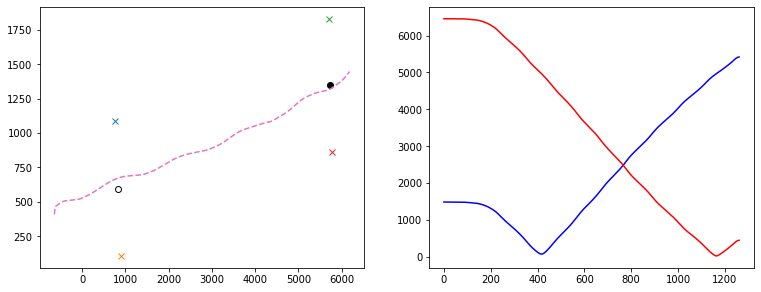

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax[0].plot(np.mean(start_1[:,0]), np.mean(start_1[:,1]), 'x')
ax[0].plot(np.mean(start_2[:,0]), np.mean(start_2[:,1]), 'x')
ax[0].plot(np.mean(end_1[:,0]), np.mean(end_1[:,1]), 'x')
ax[0].plot(np.mean(end_2[:,0]), np.mean(end_2[:,1]), 'x')
ax[0].plot(np.mean(start_[:,0]), np.mean(start_[:,1]), 'o', mec='k', mfc='none')
ax[0].plot(np.mean(end_[:,0]), np.mean(end_[:,1]), 'o', mec='k', mfc='k')
ax[0].plot(mid_psis_pos[:,0], mid_psis_pos[:,1], '--')

ax[1].plot(_get_distance_xy(mid_psis_pos, start_), '-', c='b')
ax[1].plot(_get_distance_xy(mid_psis_pos, end_), '-', c='r')

In [ ]:
# Visualize
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

# Position data
fig.add_trace(go.Scatter(x=np.arange(l_heel_pos.shape[0]), y=l_heel_pos[:,2], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_heel'), row=1, col=1)
fig.add_trace(go.Scatter(x=l_ix_IC, y=l_heel_pos[l_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(l_toe_pos.shape[0]), y=l_toe_pos[:,2], mode='lines', line=dict(color='rgba(0, 0, 255, 0.3)', width=1), name='l_toe'), row=1, col=1)
fig.add_trace(go.Scatter(x=l_ix_FC, y=l_toe_pos[l_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_heel_pos.shape[0]), y=r_heel_pos[:,2], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='r_heel'), row=1, col=1)
fig.add_trace(go.Scatter(x=r_ix_IC, y=r_heel_pos[r_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_toe_pos.shape[0]), y=r_toe_pos[:,2], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=1), name='r_toe'), row=1, col=1)
fig.add_trace(go.Scatter(x=r_ix_FC, y=r_toe_pos[r_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=1, col=1)

# Velocity (O'Connor et al.)
fig.add_trace(go.Scatter(x=np.arange(l_foot_centre_vel.shape[0]), y=l_foot_centre_vel[:,-1], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_mid_foot_vel_z'), row=2, col=1)
fig.add_trace(go.Scatter(x=l_ix_IC, y=l_foot_centre_vel[l_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=l_ix_FC, y=l_foot_centre_vel[l_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(0, 0, 255, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_foot_centre_vel.shape[0]), y=r_foot_centre_vel[:,-1], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='r_mid_foot_vel_z'), row=2, col=1)
fig.add_trace(go.Scatter(x=r_ix_IC, y=r_foot_centre_vel[r_ix_IC,-1], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=r_ix_FC, y=r_foot_centre_vel[r_ix_FC,-1], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=2, col=1)

# Relative position (Zeni Jr et al.)
fig.add_trace(go.Scatter(x=np.arange(l_heel_pos_rel.shape[0]), y=l_heel_pos_rel[:,0], mode='lines', line=dict(color='rgba(0, 0, 255, 1)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(l_toe_pos_rel.shape[0]), y=l_toe_pos_rel[:,0], mode='lines', line=dict(color='rgba(0, 0, 255, 0.3)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=l_jx_IC, y=l_heel_pos_rel[l_jx_IC,0], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(0, 0, 255, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=l_jx_FC, y=l_toe_pos_rel[l_jx_FC,0], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(0, 0, 255, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_heel_pos_rel.shape[0]), y=r_heel_pos_rel[:,0], mode='lines', line=dict(color='rgba(255, 0, 0, 1)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(r_toe_pos_rel.shape[0]), y=r_toe_pos_rel[:,0], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=1), name='l_mid_foot_vel_z'), row=3, col=1)
fig.add_trace(go.Scatter(x=r_jx_IC, y=r_heel_pos_rel[r_jx_IC,0], mode="markers", marker=dict(symbol='triangle-down-open', size=8, color='rgba(255, 0, 0, 1)')), row=3, col=1)
fig.add_trace(go.Scatter(x=r_jx_FC, y=r_toe_pos_rel[r_jx_FC,0], mode="markers", marker=dict(symbol='triangle-up-open', size=8, color='rgba(255, 0, 0, 1)')), row=3, col=1)

#
fig.add_trace(go.Scatter(x=[ix_start_, ix_start_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=[ix_start_, ix_start_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=[ix_start_, ix_start_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=3, col=1)

fig.add_trace(go.Scatter(x=[ix_end_, ix_end_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=1, col=1)
fig.add_trace(go.Scatter(x=[ix_end_, ix_end_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=2, col=1)
fig.add_trace(go.Scatter(x=[ix_end_, ix_end_], y=[0, 200], mode='lines', line=dict(color='rgba(0, 0, 0, 1)')), row=3, col=1)

fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.show()